In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
import os
import pathlib
from tqdm import tqdm
#!pip install GPUtil
import GPUtil

In [2]:
#!pip install import_ipynb
import import_ipynb
#from Dataset_moonkyung import MaskDataSet

In [3]:
class MaskDataSet(torch.utils.data.Dataset):
    def __init__(self,csv_file,root_dir,transform=None):
        self.root_dir=pathlib.Path(root_dir)
        self.transform=transform
        # 기존의 train.csv의 path값을 참조해 파일 path를 반환
        self.file_path = self.read_csv_file(csv_file,self.root_dir)
    
    def __len__(self):
        return len(self.file_path)    
    
    def __getitem__(self,idx):
        gender_labeling={
            'male':0,
            'female':1
        }
        age_labeling={
            10:0,
            20:0,
            30:1,
            40:1,
            50:1,
            60:2
        }
        mask_labeling={
            'mask':0,
            'inco':1,
            'norm':2
        }
        
        if torch.is_tensor(idx):
            idx = idx.tolist()
        # image data 불러오기
        img_path = pathlib.Path(self.root_dir,self.file_path[idx])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        
        # label data 생성
        file_folder,file_name= str(self.file_path[idx]).split('/')
        _,gender,_,age = file_folder.split('_')
        age = int(age)//10*10
        wear = file_name.split('.')[0][:4]
        y = np.array([mask_labeling[wear], gender_labeling[gender], age_labeling[age]])
            
        return torch.tensor(np.array(image)),torch.tensor(y)
    
    def read_csv_file(self,csv_file,root_dir):
        ''' Return file path using directory path in csv_file  '''
        FILE_SUFFIX = ['incorrect_mask','mask1','mask2','mask3','mask4','mask5','normal']
        # directory path 불러오기
        mask_pd = pd.read_csv(csv_file)
        # 각 directory path 안에 있는 파일 이름을 저장(확장자명 포함 X)
        suffixed_path = [pathlib.Path(path,suffix) for path in mask_pd['path'] for suffix in FILE_SUFFIX]
        # file path에서 확장자 명을 붙여준다.
        # directory path에서 내부 파일의 확장자 명을 확인
        image_extended = [next((root_dir/path).parent.glob(path.parts[-1]+'*')).suffix for path in suffixed_path]
        # file path에 확장자명을 붙여서 Serise 객체로 반환
        return [str(s_path) + i_ext for s_path,i_ext in zip(suffixed_path,image_extended)]
        

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device :',device)
class MaskModel(nn.Module):
    def __init__(self):
        super(MaskModel,self).__init__()
        self.densenet = torchvision.models.densenet161(pretrained=True)
        self.linear = nn.Linear(1000,18).to(device)
    
    def forward(self,x):
        x = self.densenet(x)
        x = nn.BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True).to(device)(x)
        return self.linear(x)
        

device : cuda


In [5]:
#!pip install ipywidgets
#!conda install -n base -c conda-forge jupyterlab_widgets
#!conda install -n py36 -c conda-forge ipywidgets
model = MaskModel().to(device)

In [6]:
data=MaskDataSet('input/data/train/train.csv','input/data/train/images',transform=transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor()]))

data_size = len(data)
data_indices = list(range(data_size))
np.random.shuffle(data_indices)
val_split_index = int(np.floor(0.2*data_size))
train_idx,val_idx = data_indices[val_split_index:],data_indices[:val_split_index]

train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
val_sampler = torch.utils.data.SubsetRandomSampler(val_idx)

train_loader = torch.utils.data.DataLoader(data,batch_size=64,shuffle=False,sampler=train_sampler,num_workers=4)
val_loader = torch.utils.data.DataLoader(data,batch_size=64,shuffle=False,sampler=val_sampler,num_workers=4)

In [7]:
from sklearn.metrics import precision_recall_fscore_support

def evaluation(model,loader):
    with torch.no_grad():
        model.eval()
        F1_score=0.0
        for batch_in,batch_out in tqdm(loader):
            batch_in = batch_in.to(device)
            y_true = batch_out.detach().cpu().numpy()
            
            pred = model.forward(batch_in).detach().cpu().numpy()
            y_pred = np.argmax(pred,axis=1)
            
            y_true[:,0] = y_true[:,0]*6
            y_true[:,1] = y_true[:,1]*3
            y_true = np.sum(y_true,axis=1)
            
            f_beta_score = precision_recall_fscore_support(y_true,y_pred,average='macro')[2]
            F1_score += f_beta_score
        F1_score = F1_score/len(loader)
    model.train()
    return F1_score

In [8]:
loss = nn.CrossEntropyLoss()
optm = torch.optim.Adam(model.parameters(),lr=1e-2)

In [9]:
import warnings
warnings.filterwarnings('ignore')

torch.cuda.empty_cache()
EPOCHS = 20
PRINT = 5

model.train()
for epoch in range(EPOCHS):
    loss_val_sum=0
    for batch_in,batch_out in tqdm(train_loader):
        batch_in,batch_out = batch_in.to(device),batch_out.to(device)
        
        y_pred = model.forward(batch_in)
        batch_out[:,0] = batch_out[:,0]*6
        batch_out[:,1] = batch_out[:,1]*3
        y_target = torch.sum(batch_out,dim=1)
        
        loss_out = loss(y_pred,y_target)
        
        optm.zero_grad()
        loss_out.backward()
        optm.step()
        loss_val_sum +=loss_out
    loss_val_avg = loss_out/len(train_loader)
    if epoch%PRINT==0:
        f1_score = evaluation(model,val_loader)
        print(f"{epoch}/{EPOCHS}, loss val avg : {loss_val_avg}, f1 score : {f1_score}")
        GPUtil.showUtilization()

  0%|          | 0/60 [00:00<?, ?it/s]

evaluation..


100%|██████████| 60/60 [00:11<00:00,  5.42it/s]


Done..!
0/20, loss val avg : 0.016293611377477646, f1 score : 0.08262113919052248
| ID | GPU | MEM |
------------------
|  0 | 67% | 56% |


  0%|          | 0/60 [00:00<?, ?it/s]

evaluation..


100%|██████████| 60/60 [00:11<00:00,  5.38it/s]


Done..!
5/20, loss val avg : 0.0450221449136734, f1 score : 0.01958913483260896
| ID | GPU | MEM |
------------------
|  0 |  0% | 56% |


  0%|          | 0/60 [00:00<?, ?it/s]

evaluation..


100%|██████████| 60/60 [00:11<00:00,  5.42it/s]


Done..!
10/20, loss val avg : 0.0338970385491848, f1 score : 0.12177655980417669
| ID | GPU | MEM |
------------------
|  0 | 20% | 56% |


  0%|          | 0/60 [00:00<?, ?it/s]

evaluation..


100%|██████████| 60/60 [00:11<00:00,  5.42it/s]


Done..!
15/20, loss val avg : 0.027772504836320877, f1 score : 0.14948027984048243
| ID | GPU | MEM |
------------------
|  0 | 28% | 56% |


100%|██████████| 237/237 [02:04<00:00,  1.90it/s]


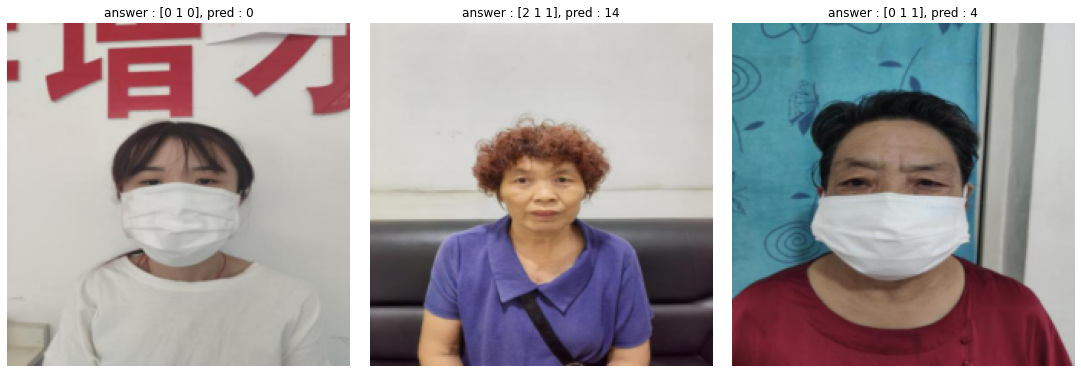

In [15]:
with torch.no_grad():
    loader = DataLoader(data,batch_size=3,shuffle=True)
    x,y = next(iter(loader))
    x = x.to(device)
    pred = model.forward(x)
    _,y_pred = torch.max(pred,dim=1)
    
    fig,axes = plt.subplots(1,len(x),constrained_layout=True,figsize=(15,5))
    for idx in range(len(x)):
        axes[idx].imshow(x[idx].permute(1,2,0).detach().cpu().numpy())
        axes[idx].set_title(f"answer : {y[idx].detach().cpu().numpy()}, pred : {y_pred[idx]}")
        axes[idx].axis('off')

In [13]:
import datetime
import pytz
def save_parameter(model,save_dir='.',file_name='model'):
    ''' Save model '''
    # import pytz
    # import datetime
    cur_time = str(datetime.datetime.now(pytz.timezone('Asia/Seoul')))
    torch.save(model,cur_time+'_'+file_name+'.pt')
    print('saved!!')
save_parameter(model,file_name='naive_dense')

saved!!


In [34]:
class TestDataset(Dataset):
    def __init__(self,images_paths,transform=None):
        self.images_paths = images_paths
        self.transform = transform
    
    def __len__(self):
        return len(self.images_paths)
    
    def __getitem__(self,idx):
        image = Image.open(self.images_paths[idx]).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return torch.tensor(np.array(image))
    

def inference(model_path,test_dir=pathlib.Path('/opt/ml/input/data/eval')):
    # meta 데이터와 이미지 경로를 불러옵니다.
    submission = pd.read_csv(test_dir/'info.csv')
    image_dir = test_dir/'images'

    # Test Dataset 클래스 객체를 생성하고 DataLoader를 만듭니다.
    image_paths = [image_dir/img_id for img_id in submission.ImageID]
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    dataset = TestDataset(image_paths, transform)

    loader = DataLoader(
        dataset,
        batch_size=32,
        shuffle=False
    )

    # 모델을 정의합니다. (학습한 모델이 있다면 torch.load로 모델을 불러주세요!)
    device = torch.device('cuda')
    model = torch.load(model_path).to(device)
    model.eval()

    # 모델이 테스트 데이터셋을 예측하고 결과를 저장합니다.
    all_predictions = []
    for images in tqdm(loader):
        with torch.no_grad():
            images = images.to(device)
            pred = model(images)
            pred = pred.argmax(dim=-1)
            all_predictions.extend(pred.cpu().numpy())
    submission['ans'] = all_predictions

    # 제출할 파일을 저장합니다.
    submission.to_csv(os.path.join(test_dir, 'submission.csv'), index=False)
    print('test inference is done!')

In [35]:
inference('./2021-08-25 08:36:09.879825+09:00naive_dense.pt')

100%|██████████| 394/394 [01:53<00:00,  3.48it/s]

test inference is done!
